In [1]:
#================================================
# EXPLORING DATA
#================================================

import duckdb, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# cria ou liga se já existir:
con = duckdb.connect("movielens100K.duckdb")

#### TABELAS DO TRABALHO
##### Tabelas do dataset original
 - Movies:
    - movieID
    - title
    - genres
 - ratings:
    - userId
    - movieId
    - rating
    - timestamp
 - links:
    - moviesId
    - imdbId
    - tmdbId
 - tags:
    - userId
    - movieId
    - tag
    - timestamp




In [2]:
# =================================================================
# Saber os 20 filmes com melhor nota (com pelo menos 50 classificações)
# =================================================================
df1 = con.sql("""
SELECT
    m.title,
    ROUND(AVG(r.rating), 2) AS media_rating,
    COUNT(*)                AS total_ratings
FROM ratings r
JOIN movies m USING (movieId)
GROUP BY m.title
HAVING COUNT(*) > 50
ORDER BY media_rating DESC, total_ratings DESC
LIMIT 20
""").df()

df1


,title,media_rating,total_ratings
0,"Shawshank Redemption, The (1994)",4.43,317
1,"Godfather, The (1972)",4.29,192
2,Fight Club (1999),4.27,218
3,Dr. Strangelove or: How I Learned to Stop Worr...,4.27,97
4,Cool Hand Luke (1967),4.27,57
5,"Godfather: Part II, The (1974)",4.26,129
6,Rear Window (1954),4.26,84
7,Goodfellas (1990),4.25,126
8,"Departed, The (2006)",4.25,107
9,"Usual Suspects, The (1995)",4.24,204


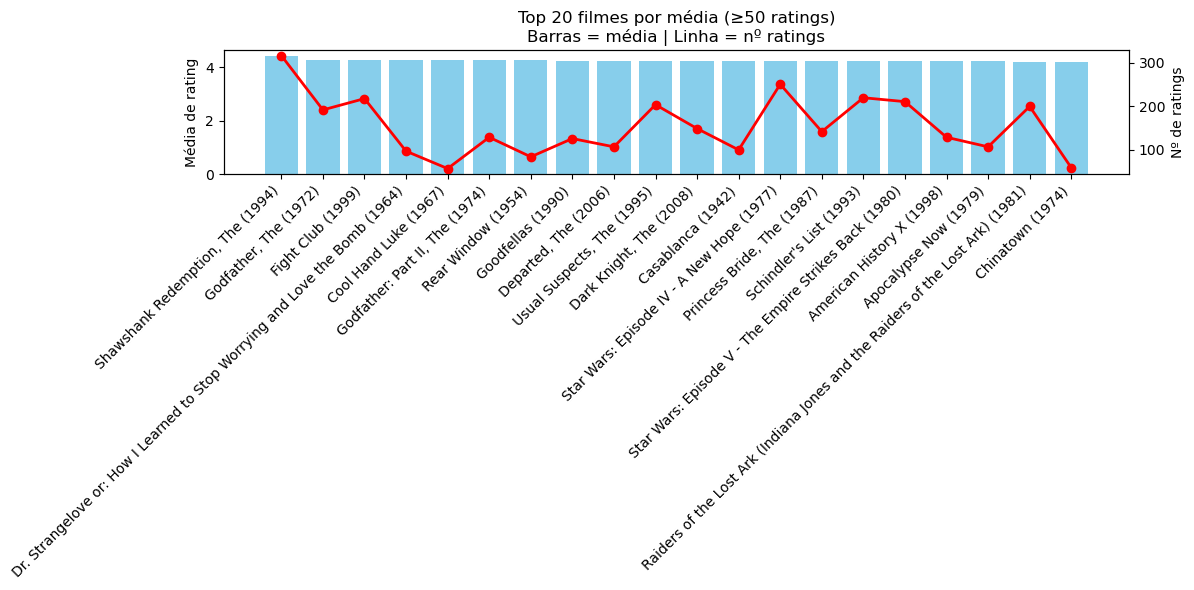

In [3]:
# Plot combinado: barras (média) + linha (nº ratings)
fig, ax1 = plt.subplots(figsize=(12, 6))

# Barras = média (AZUL)
ax1.bar(df1["title"], df1["media_rating"], color="skyblue")
ax1.set_ylabel("Média de rating")
ax1.set_xticks(range(len(df1)))
ax1.set_xticklabels(df1["title"], rotation=45, ha="right")

# Linha = nº ratings (VERMELHO)
ax2 = ax1.twinx()
ax2.plot(range(len(df1)), df1["total_ratings"], marker="o", color="red", linewidth=2)
ax2.set_ylabel("Nº de ratings")

plt.title("Top 20 filmes por média (≥50 ratings)\nBarras = média | Linha = nº ratings")
plt.tight_layout()
plt.show()



In [4]:
# =================================================================
# ranking dos 20 filmes com mais classificações (ratings)
# =================================================================

df2 = con.sql("""
SELECT
    m.title,
    COUNT(*) AS total_ratings,
    ROUND(AVG(r.rating), 2) AS media_rating
FROM ratings r
JOIN movies m USING (movieId)
GROUP BY m.title
ORDER BY total_ratings DESC, media_rating DESC
LIMIT 20
""").df()

df2




,title,total_ratings,media_rating
0,Forrest Gump (1994),329,4.16
1,"Shawshank Redemption, The (1994)",317,4.43
2,Pulp Fiction (1994),307,4.20
3,"Silence of the Lambs, The (1991)",279,4.16
4,"Matrix, The (1999)",278,4.19
5,Star Wars: Episode IV - A New Hope (1977),251,4.23
6,Jurassic Park (1993),238,3.75
7,Braveheart (1995),237,4.03
8,Terminator 2: Judgment Day (1991),224,3.97
9,Schindler's List (1993),220,4.22


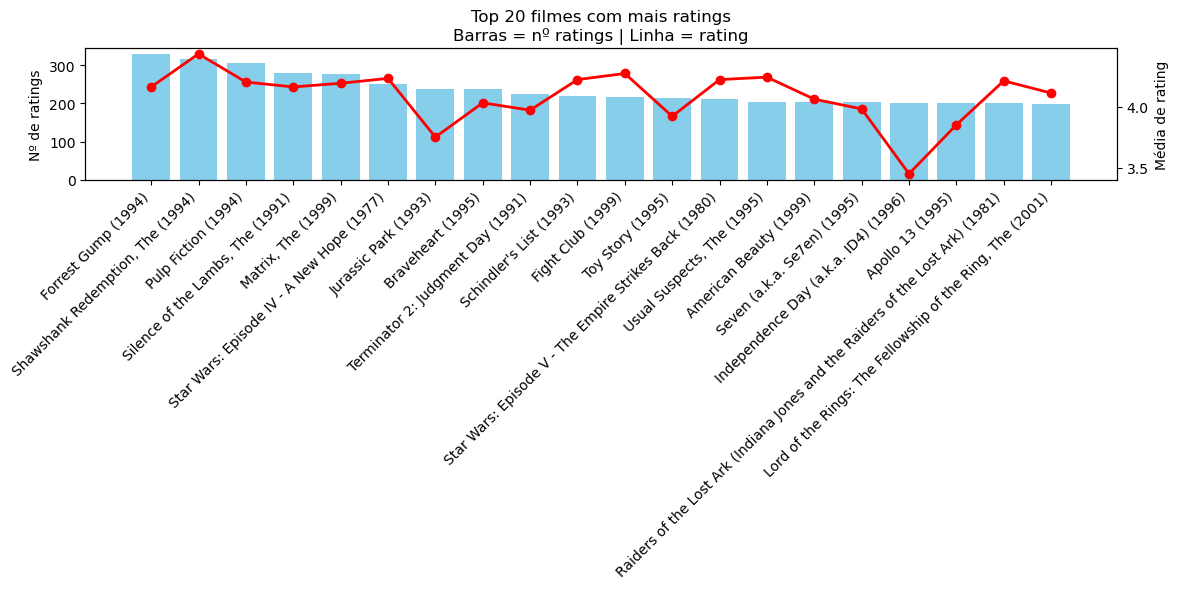

In [5]:
fig, ax1 = plt.subplots(figsize=(12,6))

# Barras = nº ratings (azul)
ax1.bar(df2["title"], df2["total_ratings"], color="skyblue")
ax1.set_ylabel("Nº de ratings")
ax1.set_xticks(range(len(df2)))
ax1.set_xticklabels(df2["title"], rotation=45, ha="right")

# Linha = média (vermelho)
ax2 = ax1.twinx()
ax2.plot(range(len(df2)), df2["media_rating"], marker="o", color="red", linewidth=2)
ax2.set_ylabel("Média de rating")

plt.title("Top 20 filmes com mais ratings\nBarras = nº ratings | Linha = rating")
plt.tight_layout()
plt.show()


In [6]:
# =================================================================
# ranking dos filmes por genero (com pelo menos 50 avaliações)
# =================================================================
df3 = con.sql("""
WITH genero_filme AS (
    SELECT
        m.movieId,
        m.title,
        unnest(string_split(m.genres, '|')) AS genre
    FROM movies m
),
stats_genero_filme AS (
    SELECT
        gf.genre,
        gf.movieId,
        gf.title,
        COUNT(*) AS total_ratings,
        AVG(r.rating) AS media_rating
    FROM genero_filme gf
    JOIN ratings r
      ON r.movieId = gf.movieId
    GROUP BY gf.genre, gf.movieId, gf.title
    HAVING COUNT(*) >= 50          -- 👈 mínimo de 10 ratings
),
ranking_por_genero AS (
    SELECT
        genre,
        movieId,
        title,
        total_ratings,
        media_rating,
        ROW_NUMBER() OVER (
            PARTITION BY genre
            ORDER BY media_rating DESC, total_ratings DESC
        ) AS posicao
    FROM stats_genero_filme
)
SELECT
    genre,
    title,
    ROUND(media_rating, 2) AS media_rating,
    total_ratings
FROM ranking_por_genero
WHERE posicao = 1
ORDER BY genre
""").df()

df3

,genre,title,media_rating,total_ratings
0,Action,Fight Club (1999),4.27,218
1,Adventure,"Princess Bride, The (1987)",4.23,142
2,Animation,Spirited Away (Sen to Chihiro no kamikakushi) ...,4.16,87
3,Children,Toy Story 3 (2010),4.11,55
4,Comedy,Dr. Strangelove or: How I Learned to Stop Worr...,4.27,97
5,Crime,"Shawshank Redemption, The (1994)",4.43,317
6,Documentary,Bowling for Columbine (2002),3.78,58
7,Drama,"Shawshank Redemption, The (1994)",4.43,317
8,Fantasy,"Princess Bride, The (1987)",4.23,142
9,Film-Noir,Chinatown (1974),4.21,59


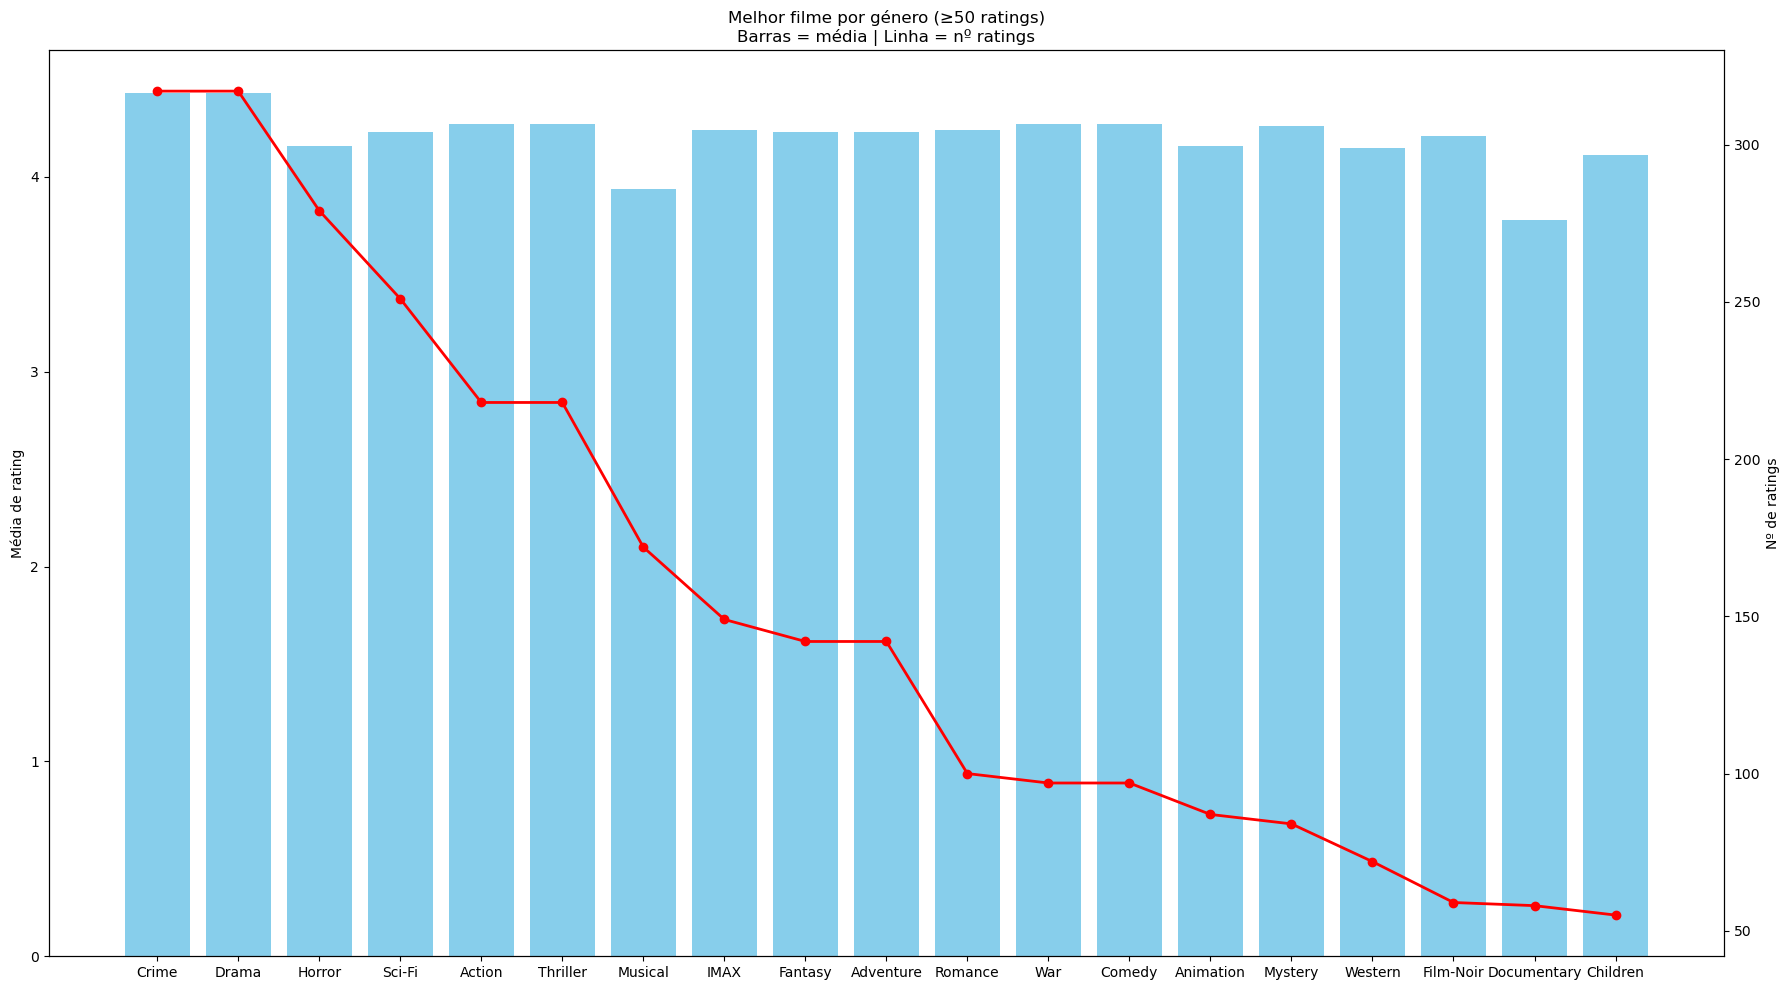

In [7]:
df3_plot = df3.sort_values("total_ratings", ascending=False)

x = np.arange(len(df3_plot))   # 0..N-1

fig, ax1 = plt.subplots(figsize=(18,10))
# Barras = média
ax1.bar(x, df3_plot["media_rating"], color="skyblue")
ax1.set_ylabel("Média de rating")

# Linha = nº ratings
ax2 = ax1.twinx()
ax2.plot(x, df3_plot["total_ratings"], marker="o", color="red", linewidth=2)
ax2.set_ylabel("Nº de ratings")

# Géneros como labels verticais
plt.xticks(x, df3_plot["genre"], rotation=90)
plt.title("Melhor filme por género (≥50 ratings)\nBarras = média | Linha = nº ratings")

plt.tight_layout()
plt.show()


In [8]:
# =================================================================
# ranking dos filmes + avaliados por genero (com pelo menos 50 avaliações)
# =================================================================

con.sql("""
WITH genero_filme AS (
    SELECT
        m.movieId,
        m.title,
        unnest(string_split(m.genres, '|')) AS genre
    FROM movies m
),
stats_genero_filme AS (
    SELECT
        gf.genre,
        gf.movieId,
        gf.title,
        COUNT(*) AS total_ratings,
        AVG(r.rating) AS media_rating
    FROM genero_filme gf
    JOIN ratings r
      ON r.movieId = gf.movieId
    GROUP BY gf.genre, gf.movieId, gf.title
    HAVING COUNT(*) >= 50  -- mantém só filmes com pelo menos 50 avaliações
),
ranking_por_genero AS (
    SELECT
        genre,
        movieId,
        title,
        total_ratings,
        media_rating,
        ROW_NUMBER() OVER (
            PARTITION BY genre
            ORDER BY total_ratings DESC, media_rating DESC
        ) AS posicao
    FROM stats_genero_filme
)
SELECT
    genre,
--    posicao,
    title,
    total_ratings,
    ROUND(media_rating, 2) AS media_rating
FROM ranking_por_genero
WHERE posicao <= 1
ORDER BY genre, posicao
""").df()

,genre,title,total_ratings,media_rating
0,Action,"Matrix, The (1999)",278,4.19
1,Adventure,Star Wars: Episode IV - A New Hope (1977),251,4.23
2,Animation,Toy Story (1995),215,3.92
3,Children,Toy Story (1995),215,3.92
4,Comedy,Forrest Gump (1994),329,4.16
5,Crime,"Shawshank Redemption, The (1994)",317,4.43
6,Documentary,Bowling for Columbine (2002),58,3.78
7,Drama,Forrest Gump (1994),329,4.16
8,Fantasy,Toy Story (1995),215,3.92
9,Film-Noir,L.A. Confidential (1997),97,4.06


In [9]:
# ================================================
# Saber os tags mais frequentes
# ================================================

con.sql("""
SELECT
    LOWER(TRIM(word)) AS palavra,
    COUNT(*) AS total
FROM (
    SELECT unnest(string_split(tag, ' ')) AS word
    FROM tags
)
WHERE palavra <> ''
  AND LENGTH(palavra) > 2
  AND palavra NOT IN ('the', 'and', 'for', 'with', 'this', 'that', 'are')
GROUP BY palavra
ORDER BY total DESC
LIMIT 30
""").df()

,palavra,total
0,netflix,134
1,queue,131
2,comedy,64
3,dark,47
4,atmospheric,41
5,ending,30
6,space,28
7,funny,28
8,sci-fi,27
9,bad,27


In [10]:
# ================================================
# Saber o tag mais repetido por filme:
# ================================================

df_tags=con.sql("""
WITH palavras_por_filme AS (
    SELECT
        t.movieId,
        LOWER(TRIM(word)) AS palavra,
        COUNT(*) AS total
    FROM (
        SELECT movieId, unnest(string_split(tag, ' ')) AS word
        FROM tags
    ) t
    WHERE palavra <> ''
      AND LENGTH(palavra) > 2
      AND palavra NOT IN ('the', 'and', 'for', 'with', 'this', 'that', 'are', 'was')
    GROUP BY t.movieId, palavra
),
ranking_por_filme AS (
    SELECT
        movieId,
        palavra,
        total,
        ROW_NUMBER() OVER (PARTITION BY movieId ORDER BY total DESC) AS posicao
    FROM palavras_por_filme
)
SELECT
    m.movieId,
    m.title,
    r.palavra,
    r.total
FROM ranking_por_filme r
JOIN movies m USING (movieId)
WHERE r.posicao <= 5
ORDER BY r.total DESC
LIMIT 20
""").df()

df_tags

,movieId,title,palavra,total
0,296,Pulp Fiction (1994),violence,6
1,260,Star Wars: Episode IV - A New Hope (1977),sci-fi,6
2,260,Star Wars: Episode IV - A New Hope (1977),space,6
3,750,Dr. Strangelove or: How I Learned to Stop Worr...,comedy,5
4,260,Star Wars: Episode IV - A New Hope (1977),classic,5
5,296,Pulp Fiction (1994),dialogue,5
6,2959,Fight Club (1999),dark,4
7,296,Pulp Fiction (1994),cult,4
8,1200,Aliens (1986),space,4
9,296,Pulp Fiction (1994),crime,4


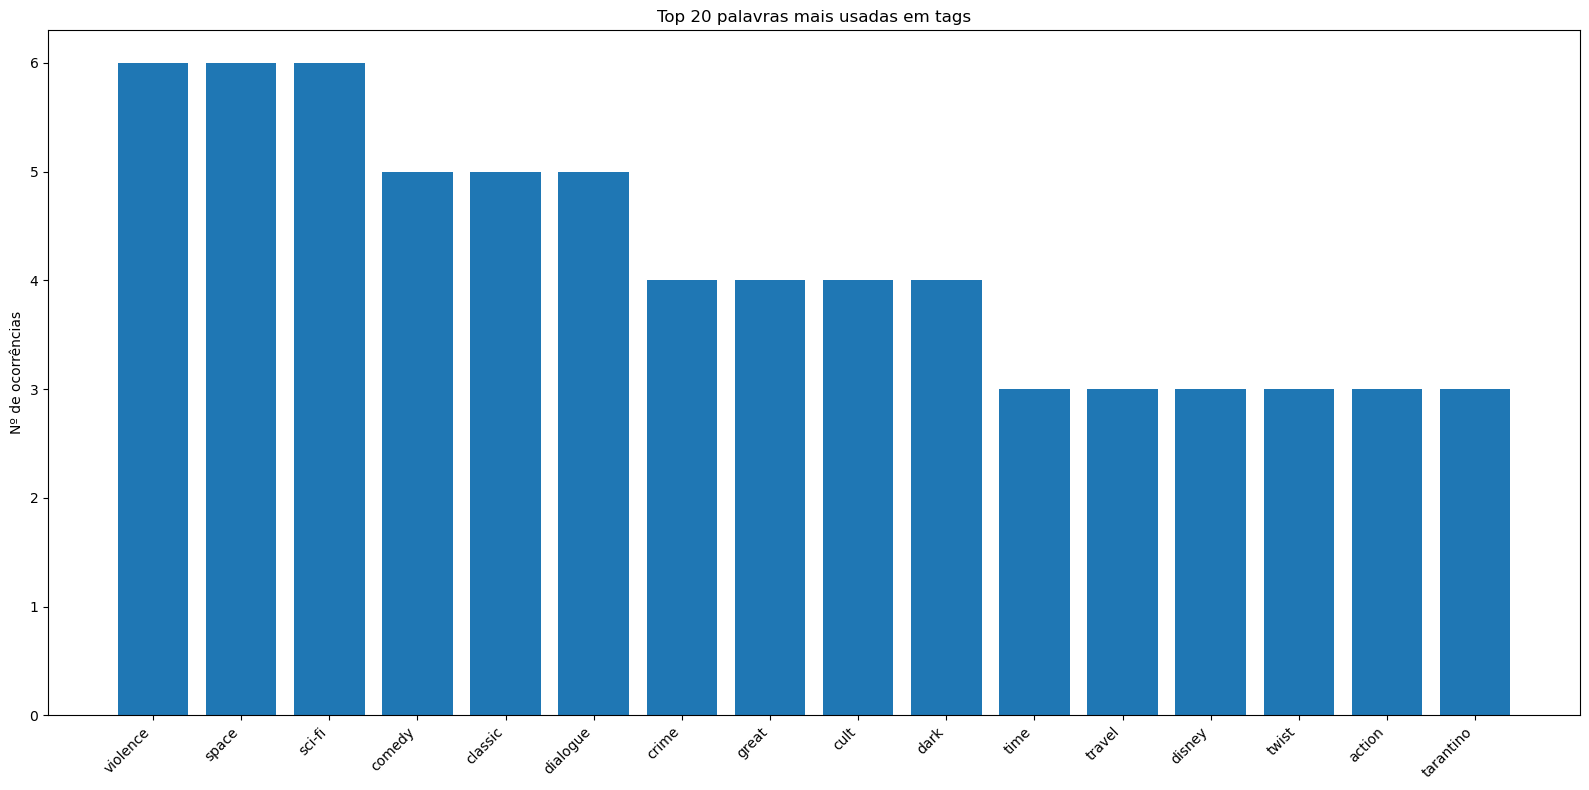

In [11]:
# Top 10 palavras
df_top = df_tags.sort_values("total", ascending=False).head(20)

plt.figure(figsize=(16,8))
plt.bar(df_top["palavra"], df_top["total"])
plt.title("Top 20 palavras mais usadas em tags")
plt.ylabel("Nº de ocorrências")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [12]:
# ================================================
# Saber os users com mais qt de ratings e nota média
# ================================================

con.sql("""
SELECT
    r.userId,
    COUNT(*) AS total_ratings,
    ROUND(AVG(r.rating), 2) AS media_rating
FROM ratings r
GROUP BY r.userId
ORDER BY total_ratings DESC, media_rating DESC
LIMIT 20
""").df()

,userId,total_ratings,media_rating
0,414,2698,3.39
1,599,2478,2.64
2,474,2108,3.40
3,448,1864,2.85
4,274,1346,3.24
5,610,1302,3.69
6,68,1260,3.23
7,380,1218,3.67
8,606,1115,3.66
9,288,1055,3.15


In [13]:
df_users = con.sql("""
SELECT
    userId,
    COUNT(*) AS total_ratings,
    ROUND(AVG(rating), 2) AS media_rating
FROM ratings
GROUP BY userId
""").df()


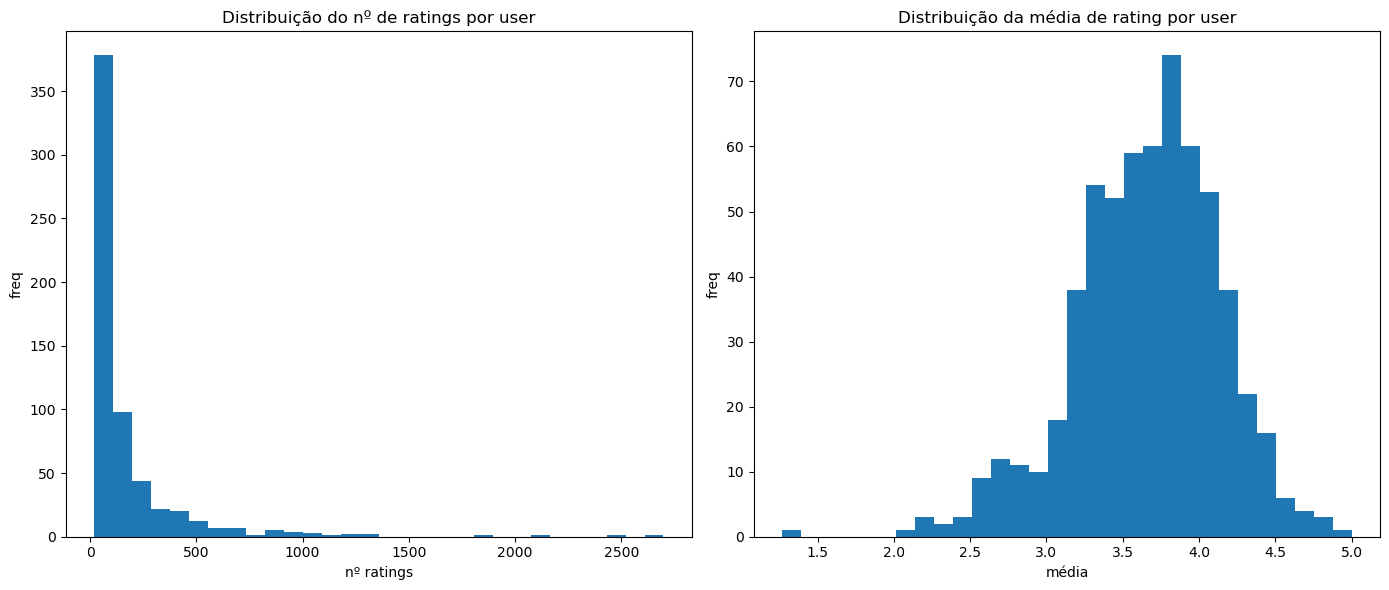

In [14]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14,6))

# hist nº ratings
axes[0].hist(df_users["total_ratings"], bins=30)
axes[0].set_title("Distribuição do nº de ratings por user")
axes[0].set_xlabel("nº ratings")
axes[0].set_ylabel("freq")

# hist média ratings
axes[1].hist(df_users["media_rating"], bins=30)
axes[1].set_title("Distribuição da média de rating por user")
axes[1].set_xlabel("média")
axes[1].set_ylabel("freq")

plt.tight_layout()
plt.show()


#### Fechar a ligação

In [15]:
con.close()
print("Ligação fechada.")

Ligação fechada.
